# Construction d'un réseau de neurones.

Ce cahier est en majeur partie copié de cette [page](https://www.miximum.fr/blog/introduction-au-deep-learning-1/) du site Miximum.

## Construction d'un premier réseau

Voici le schema d'un neurone, qui fait donc la somme pondérée des entrées et ensuite donne une sortie en passant par un filtre fait par une fonction sigmoïde.

![schéma d'un neurone](./img/neurone.png)

Nous construisons ce neurone sous forme d'une classe. Ce neurone reçoit un certains nombre d'entrées dont il fait une somme pondérée puis un filtrage par la fonction sigmoïde. À son initialisation, les poids donnés à chaque entrée sont aléatoires.

In [1]:
import numpy as np

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

class Neuron:
    def __init__(self, input_size):
        """Initialisation des poids / biais avec des valeurs aléatoires."""
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn()

    def activation(self, X):
        """On suppose que X est de la taille passée dans le constructeur."""
        aggregation = np.sum(X * self.weights) + self.bias
        return sigmoid(aggregation)


Les neurones vont être ensuite rassemblés dans une réseau organisé par couches. Ces couches vont qualifier la profondeur du réseau.

![réseau de neurones](./img/reseau.png)

Voici aussi la classe pour définir chacune de ces couches. Les couches ont deux propriétés: le nombre des neurones dans la couche et le nombre d'entrées arrivant dans chaque neurone de cette couche.

La méthode `forward` qui s'applique à cette objet `layer` fait ici appelle à deux méthodes, l'`aggregation` qui est la somme pondérée et l'activation, qui est le filtrage par la fonction sigmoïde.

In [2]:
class Layer:
    """Une seule couche de neurones."""
    def __init__(self, size, input_size):
        self.size = size
        self.input_size = input_size

        # Les poids sont représentés par une matrice de n lignes
        # et m colonnes. n = le nombre de neurones, m = le nombre de
        # neurones dans la couche précédente.
        self.weights = np.random.randn(size, input_size)

        # Un biais par neurone
        self.biases = np.random.randn(size)

    # Résultat du calcul de chaque neurone.
    # Il est important de noter que `data` est un vecteur (normalement, de
    # longueur `self.input_size`, et que nous retournons un vecteur de
    # taille `self.size`.
    def forward(self, data):
        aggregation = self.aggregation(data)
        activation = self.activation(aggregation)
        return activation

    # Calcule la somme des entrées pondérées + biais pour chaque neurone.
    # Plutôt que d'utiliser une boucle for, nous tirons parti du calcul
    # matriciel qui permet d'effectuer toutes ces opérations d'un coup.
    def aggregation(self, data):
        # return np.dot(self.weights, data) + self.biases
        return self.weights @ data + self.biases  # forme équivalente à np.dot(x,y)

    # Passe les valeurs aggrégées dans la moulinette de la fonction
    # d'activation.
    # `x` est un vecteur de longueur `self.size`, et nous retournons un
    # vecteur de même dimension.
    def activation(self, x):
        return sigmoid(x)


Le réseau va être ensuite constitué d'une liste de couches. Il y a aussi toujours une dimension pour les entrées. La méthode `add_layer` ajoute couche dans la liste de couche du réseau. La méthode `feedforward` ne fait que de propager cette méthode au travers des couches. La méthode `predict` donne la sortie du réseau et la méthode `evaluate` donne un idée de la performance de la reconnaissance faite par le réseau.

In [3]:
class Network:
    """Un réseau constitué de couches de neurones."""
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.layers = []

    def add_layer(self, size):
        if len(self.layers) > 0:
            input_dim = self.layers[-1].size
        else:
            input_dim = self.input_dim
        self.layers.append(Layer(size, input_dim))

    # Propage les données d'entrée d'une couche à l'autre.
    def feedforward(self, input_data):
        activation = input_data
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation

    # Retourne l'index du neurone de sortie qui a la plus haute valeur, ce
    # qui revient à indiquer quelle classe est sélectionnée par le réseau.
    def predict(self, input_data):
        return np.argmax(self.feedforward(input_data))

    # Évalue la performance du réseau à partir d'un set d'exemples.
    # Retourne un nombre entre 0 et 1.
    def evaluate(self, X, Y):
        results = [1 if self.predict(x) == y else 0 for (x, y) in zip(X, Y)]
        accuracy = sum(results) / len(results)
        return accuracy

## Les données pour tester le réseau neuronal.

L'extension [sklearn.datasets](https://scikit-learn.org/stable/datasets.html) propose différents jeux de données pour exercer des outils de reconnaissance. Parmi eux, nous utiliseront la jeux appelé [digits](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits). L'objectif pour le réseau neuronal sera de classer ces images selon le chiffre reconnu entre 0 et 9.

Les lignes de codes ci-dessous affichent quelques exemples d'images venant de ces donnéeS.

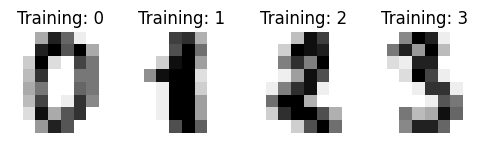

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(6, 2))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

Dans tous les exercices de reconnaissances, il est d'usage de diviser les données en deux ensembles: une partie pour l'apprentissage et l'autre pour vérifier le résultat. Voici la méthode que nous utiliserons pour récupérer ces deux ensembles.

In [5]:
from sklearn.utils import shuffle

def load_data():
    digits = datasets.load_digits()
    
    # il faut mélanger les entrées, ce qu'on fait en mélangeant les indices
    rng = np.random.RandomState(0)
    indices = np.arange(len(digits.data))
    rng.shuffle(indices)

    # divide the dataset into learning et test sets
    X = digits.data[indices[:300]]
    y = digits.target[indices[:300]]
    image = digits.images[:300]
    
    return X, y, image


Maintenant que nous avons notre réseau de neurones et un jeu de données, faisons notre premier essai.

In [6]:
X_test, y_test, image_test = load_data()

net = Network(input_dim=64)
net.add_layer(200)
# net.add_layer(10)

accuracy = net.evaluate(X_test, y_test)
print('Performance initiale : {:.2f}%'.format(accuracy * 100.0))


Performance initiale : 6.67%


Vous n'aurez sûrement pas une bonne performance avec ce premier essai: nous avons pris des poids au hasard et nous nous avons fait fonctionner le réseau sans lui avoir fait faire auparavant une phase d'apprentissage.

## Construction d'un réseau avec possibilité d'apprentissage.

### Mise en place du réseau et des notations.

Le [cahier suivant](https://www.miximum.fr/blog/introduction-au-deep-learning-2/) de Miximum expose comment introduire une notion d'apprentissage dans le réseau neuronal que nous avons construit. Pour réaliser un apprentissage, il faut une fonction de coût qui va nous dire de combien on est éloigné de la solution. Le cahier sur les [concepts](./00_concepts.ipynb) a exposé une méthode classique est bien connue qui est l'algorithme du gradient. Nous allons utiliser la même chose, mais en l'appliquant à ce réseau.

Nous allons d'abord commencer par un rappel sur les notations.

![réseau neuronal](./img/reseau_poids.png)


- $L$ est le nombre de couches du neurones.
- $\sigma$ est la fonction d'activation Sigmoïde.
- $w_{ij}$ est le poids qui relie le $i^\text{ième}$ neurone de la $l^\text{ième}$ couche au $j^\text{ième}$ neurone de la $(l - 1)^\text{ième}$ couche.
- $w^l$ est une matrice de taille $i\times j$ ($i$ lignes et $j$ colonnes) qui contient tous les poids de la $l^\text{ième}$ couche.
- $b_i^l$ est le biais associé au $i^\text{ième}$ neurone de la $l^\text{ième}$ couche.
- $b^l$ est le vecteur qui contient tous les biais de la $l^\text{ième}$ couche.

$Z_i^l$ est la valeur d'aggrégation du $i^\text{ième}$ neurone de la $l^\text{ième}$ couche, c'est-à-dire la valeur qu'un neurone calcule avant de passer à la fonction d'activation.

$$ z_i^l = \sum_{j=1}^m w_{ij}^l a_j^{l-1} + b_i^l$$

$a_i^l$ est la valeur d'activation du $i^\text{ième}$ neurone de la $l^\text{ième}$ couche, c'est-à-dire la valeur définitive retournée par le neurone : $ a_i^l = \sigma(z_l^l)$.

En utilisant la notation vectorielle (les vecteurs sont notés par des majuscules),

$$ 
Z^l = \left(\begin{array}{c}z_1^l \\ z_2^l \\ \vdots \\ z_n^l \end{array}\right)
\quad \quad
A^l = \left(\begin{array}{c}a_1^l \\ a_2^l \\ \vdots \\ a_n^l \end{array}\right)
$$ 

on peut écrire.

$$\begin{align}
Z^l &= W^l \circ A^{l-1} + B^l \\
A^l &= \sigma(Z^l) \\
\end{align}$$

Pour chaque couche on passe la première équation qui est l'agrégation sur tous les neurones de la couche (ce qu'on peut faire une seule opération en utilisant une notation vectorielle) et en appliquant ensuite le filtre d'activation.

### Évaluer une estimation.

Le réseau peut être représenté ainsi: à partir d'une entrée $X$ on obtient une sortie $Y$ et l'objectif est que cette sortie soit la plus proche possible de $T$, la cible (la *target*).

![réseau en forward](./img/reseau_XYT.png)

Si le réseau n'est pas entraîné (comme dans notre exemple précédent avec des poids de départ aléatoires), il y a beaucoup de chance que $Y$ soit différent de $T$. On va caractériser la distance à notre cible avec une fonction de la forme suivante.

$$ C(W) = \frac{1}{2m} (Y - T)^2$$

(revoir le cahier sur les [concepts](00_concepts.ipynb))

Nous savons bien évaluer cette erreur entre le résultat sortant de la dernière couche du réseau et la cible, mais il va falloir ensuite propager cette évaluation d'erreur en arrière dans les couches du réseau.

![réseau rétropropagation](./img/reseau_backward.png)

Chaque couche reçoit donc une erreur $\delta^{l}$ et on applique alors l'algorithme du gradient pour changer les coefficients à l'intérieur de cette couche. C'est le calcul de rétro-propagation du gradient.

On voit aussi le nombre de calcul nécessaire et il faut donc pouvoir faire des calculs efficaces pour espérer avoir un résultat en un temps raisonnable.

### Répartir l'erreur sur la dernière couche.

Dès qu'on change un poids, tout le réseau est impacté.

![réseau et impact d'un changement](./img/reseau_impact.png)

Imaginons une modification très petite sur le poids $w_{11}^L$ que l'on note $dw_{11}^L$, cette modification aura un impact sur le résultat :

$$ \frac{\partial C}{\partial w_{11}^L}dw_{11}^l = dC $$

Mais cette modification va aussi impacter le résultat élémentaire $z_1^L de la façon suivante.

$$ \frac{\partial z_1^L}{\partial w_{11}^L} dw_{11}^l = dz_1^L$$

et l'impact sur $z_1^L$ aura un impact sur $a_1^L$

$$ \frac{\partial a_1^L}{\partial z_1^L} dz_1^l = da_1^L$$

et puisque la la sortie dépend de $a_1^L$, la fonction de coût aussi.

$$\frac{\partial C}{\partial a_1^L} da_1^L = dC $$

$$\frac{\partial C}{\partial a_1^L} = \frac{}{m}(Y - T) $$

On peut combiner les équations précédentes pour obtenir.

$$ \frac{\partial C}{\partial w_{11}^L} =\frac{\partial z_1^L}{\partial w_{11}^L} 
                                         \frac{\partial a_1^L}{\partial z_1^L}
                                         \frac{\partial C}{\partial a_1^L}$$

La dérivée $\displaystyle \partial C / \partial a_1^L$ est la dérivée de la fonction de coût qui sera simple à calculer. Dans le [cahier sur les concepts](00_concepts.ipynb) nous avons vu que pour cette dernière couche on pourra calculer

$$\frac{dC}{dW} = \frac{1}{m} (Y - T)^T \circ (Y - T)$$

avec la définition que nous avons donnée.

La dérivée $\partial a_1^L / \partial z_1^L$ est la dérivée de la fonction d'activation. Si on utilise la fonction Sigmoïde $\sigma$, on sait que le résultat sera simple.

$$\frac{\partial a_1^L}{\partial z_1^L} = \sigma'(z_1^L) = \sigma(z_1^L) \big(1 - \sigma(z_1^L)\big)$$

La dérivée $\partial z_1^L / \partial w_{11}^L$ est la variation de la fonction d'agrégation en fonction de ce seul poids, donc le résultat est aussi simple.

$$\frac{\partial z_1^L}{\partial w_{11}^L} = a_1^{L-1}$$

Et donc en récapitulant, on obtient l'équation suivante.

$$ \frac{\partial C}{\partial w_{11}^L} = a_1^{L-1} 
                                          \sigma'(z_1^L)                                          \frac{dC}{da_1^L}$$

Or la variation $\partial C / \partial z_1^L$ est la composante $1$ de l'erreur $\delta^L$.

$$\frac{\partial C}{\partial z_1^L} = 
     \frac{\partial a_1^L}{\partial z_1^L}\frac{\partial C}{\partial a_1^L} =
     \sigma'(z_1^L) \frac{dC}{da_1^L} = \delta_1^L$$

On obtient finalement

$$\frac{\partial C}{\partial w_{ij}^L} = a_j^{L-1} \cdot \delta_i^L$$

### Rétro-propagager le calcul des erreurs.

Nous allons maintenant voir comment retro-propager ce calcul d'erreur sur les autres couches.

![réseau et impact d'un changement](./img/reseau_impact.png)

Voici par exemple sur la quatrième couche.

$$ \frac{\partial C}{\partial w_{12}^4} = \frac{\partial z_1^4}{\partial w_{12}^4}
                                          \frac{\partial a_1^4}{\partial z_1^4}
                                          \frac{C}{\partial a_1^4}$$

Le premier terme $\partial z_1^4 / \partial w_{12}^4$ est la variation de la fonction d'agrégation, donc on a 

$$\frac{\partial z_1^4}{\partial w_{12}^4} = a_2^3$$

Le second terme $\partial a_1^4 / \partial z_1^4$ désigne la variation de la fonction d'activation.

$$\frac{\partial a_1^4}{\partial z_1^4} = \sigma'(z_1^4)$$

Pour le dernier terme $\partial C / \partial a_1^4$ on remarque que s'il est modifié, il aura un impact sur $z_1^L$, $z_2^L$ et $z_3^L$ et on va donc écrire.

$$\frac{\partial C}{\partial a_1^4} = \frac{\partial z_1^L}{\partial a_1^4}
                                      \frac{\partial C}{\partial z_1^L} +
                                      \frac{\partial z_2^L}{\partial a_1^4}
                                      \frac{\partial C}{\partial z_2^L} +
                                      \frac{\partial z_3^L}{\partial a_1^4}
                                      \frac{\partial C}{\partial z_3^L}
                                    = \sum_k \frac{\partial z_k^L}{\partial a_1^4}
                                             \frac{\partial C}{\partial z_k^L}$$

En sachant qu'on a vu que 

$$ \frac{\partial C}{\partial z_k^L} = \delta_k^L$$

et pour l'autre terme, on vérifie que

$$\frac{\partial z_k^L}{\partial a_1^4} = w_{k1}^L$$

et donc 

$$\frac{\partial C}{\partial w_{12}^4} = a_2^3 \cdot \sigma'(z_1^4) \sum_k w_{k1}^L \delta_k^L$$

On peut ensuite généraliser à tous les termes. Il existe un [article en anglais](http://neuralnetworksanddeeplearning.com/chap2.html#the_four_fundamental_equations_behind_backpropagation) donnant une explication détaillée du calcul de rétro-propagation.

## La deuxième version avec apprentissage.

Pour la deuxième version avec apprentissage, nous revoyons la fonction de récupération des données, qui seront séparées en un échantillon pour l'apprentissage et une version pour tester.

In [13]:
def load_data():
    digits = datasets.load_digits()
    
    # shuffle the datasets
    rng = np.random.RandomState(0)
    indices = np.arange(len(digits.data))
    rng.shuffle(indices)

    # divide the dataset into learning et test sets
    X_learn = digits.data[indices[:330]]
    y_learn = digits.target[indices[:330]]
    X_test = digits.data[indices[331:]]
    y_test = digits.target[indices[331:]]

    return X_learn, y_learn, X_test, y_test


Nous avons vu que nous aurons besoin de la dérivée de la fonction sigmoïde.

In [8]:
def sigmoid_prime(x):
    """Dérivée de la fonction sigmoid."""
    return sigmoid(x) * (1.0 - sigmoid(x))

On redéfinit une classe `layer` avec la possibilité de retro-propagation, qui est donnée par les trois dernières méthodes.

In [10]:
class Layer2:
    """Une seule couche de neurones."""
    def __init__(self, size, input_size):
        self.size = size
        self.input_size = input_size

        # Les poids sont représentés par une matrice de n lignes
        # et m colonnes. n = le nombre de neurones, m = le nombre de
        # neurones dans la couche précédente.
        self.weights = np.random.randn(size, input_size)

        # Un biais par neurone
        self.biases = np.random.randn(size)

    # Résultat du calcul de chaque neurone.
    # Il est important de noter que `data` est un vecteur (normalement, de
    # longueur `self.input_size`, et que nous retournons un vecteur de
    # taille `self.size`.
    def forward(self, data):
        aggregation = self.aggregation(data)
        activation = self.activation(aggregation)
        return activation

    # Calcule la somme des entrées pondérées + biais pour chaque neurone.
    # Plutôt que d'utiliser une boucle for, nous tirons parti du calcul
    # matriciel qui permet d'effectuer toutes ces opérations d'un coup.
    def aggregation(self, data):
        return np.dot(self.weights, data) + self.biases

    # Passe les valeurs aggrégées dans la moulinette de la fonction
    # d'activation.
    # `x` est un vecteur de longueur `self.size`, et nous retournons un
    # vecteur de même dimension.
    def activation(self, x):
        return sigmoid(x)

    # Dérivée de la fonction d'activation.
    def activation_prime(self, x):
        return sigmoid_prime(x)

    # Mise à jour des poids à partir du gradient (algo du gradient)
    def update_weights(self, gradient, learning_rate):
        self.weights -= learning_rate * gradient

    # Idem mais avec les biais
    def update_biases(self, gradient, learning_rate):
        self.biases -= learning_rate * gradient


La programmation du réseau est la partie la plus modifiée. Nous aurons besoin pour cette méthode d'une fonction `one_hot` qui ne conserve qu'une des coordonnées.

In [15]:
def to_one_hot(y, k):
    """Convertit un entier en vecteur "one-hot".

    to_one_hot(5, 10) -> (0, 0, 0, 0, 1, 0, 0, 0, 0)

    """
    one_hot = np.zeros(k)
    one_hot[y] = 1
    return one_hot

In [16]:
class Network2:
    """Un réseau constitué de couches de neurones."""
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.layers = []

    def add_layer(self, size):
        if len(self.layers) > 0:
            input_dim = self.layers[-1].size
        else:
            input_dim = self.input_dim
        self.layers.append(Layer2(size, input_dim))

    # Propage les données d'entrée d'une couche à l'autre.
    def feedforward(self, input_data):
        activation = input_data
        for layer in self.layers:
            activation = layer.forward(activation)
        return activation

    # Retourne l'index du neurone de sortie qui a la plus haute valeur, ce
    # qui revient à indiquer quelle classe est sélectionnée par le réseau.
    def predict(self, input_data):
        return np.argmax(self.feedforward(input_data))

    # Évalue la performance du réseau à partir d'un set d'exemples.
    # Retourne un nombre entre 0 et 1.
    def evaluate(self, X, Y):
        results = [1 if self.predict(x) == y else 0 for (x, y) in zip(X, Y)]
        accuracy = sum(results) / len(results)
        return accuracy

    # Fonction d'entraînement du modèle qui va permettre de mettre à jour les poids.
    def train(self, X, Y, steps=30, learning_rate=0.3, batch_size=10):
        n = Y.size
        for i in range(steps):
            # Mélangeons les données parce que… parce que.
            X, Y = shuffle(X, Y)
            for batch_start in range(0, n, batch_size):
                X_batch, Y_batch = X[batch_start:batch_start + batch_size], Y[batch_start:batch_start + batch_size]
                self.train_batch(X_batch, Y_batch, learning_rate)

    # Cette fonction combine les algos du rétro-propagation du gradient +
    # gradient descendant.
    def train_batch(self, X, Y, learning_rate):
        # Initialise les gradients pour les poids et les biais.
        weight_gradient = [np.zeros(layer.weights.shape) for layer in self.layers]
        bias_gradient = [np.zeros(layer.biases.shape) for layer in self.layers]

        # On fait tourner l'algo de rétro-propagation pour calculer les
        # gradients un certain nombre de fois. On fera la moyenne ensuite.
        for (x, y) in zip(X, Y):
            new_weight_gradient, new_bias_gradient = self.backprop(x, y)
            weight_gradient = [wg + nwg for wg, nwg in zip(weight_gradient, new_weight_gradient)]
            bias_gradient = [bg + nbg for bg, nbg in zip(bias_gradient, new_bias_gradient)]

        # C'est ici qu'on calcule les moyennes des gradients calculés
        avg_weight_gradient = [wg / Y.size for wg in weight_gradient]
        avg_bias_gradient = [bg / Y.size for bg in bias_gradient]

        # Il ne reste plus qu'à mettre à jour les poids et biais en
        # utilisant l'algo du gradient descendant.
        for layer, weight_gradient, bias_gradient in zip(self.layers,
                                                         avg_weight_gradient,
                                                         avg_bias_gradient):
            layer.update_weights(weight_gradient, learning_rate)
            layer.update_biases(bias_gradient, learning_rate)

    # L'algorithme de rétro-propagation du gradient.
    # C'est là que tout le boulot se fait.
    def backprop(self, x, y):

        # On va effectuer une passe vers l'avant, une passe vers l'arrière
        # On profite de la passe vers l'avant pour stocker les calculs
        # intermédiaires, qui seront réutilisés par la suite.
        aggregations = []
        activation = x
        activations = [activation]

        # Propagation pour obtenir la sortie
        for layer in self.layers:
            aggregation = layer.aggregation(activation)
            aggregations.append(aggregation)
            activation = layer.activation(aggregation)
            activations.append(activation)

        # Calculons la valeur delta (δ) pour la dernière couche
        # en appliquant les équations détaillées plus haut.
        target = to_one_hot(int(y), 10)
        delta = self.get_output_delta(aggregation, activation, target)
        deltas = [delta]

        # Phase de rétropropagation pour calculer les deltas de chaque
        # couche
        # On utilise une implémentation vectorielle des équations.
        nb_layers = len(self.layers)
        for l in reversed(range(nb_layers - 1)):
            layer = self.layers[l]
            next_layer = self.layers[l + 1]
            activation_prime = layer.activation_prime(aggregations[l])
            delta = activation_prime * np.dot(next_layer.weights.transpose(), delta)
            deltas.append(delta)

        # Nous sommes parti de l'avant-dernière couche pour remonter vers
        # la première. deltas[0] contient le delta de la dernière couche.
        # Nous l'inversons pour faciliter la gestion des indices plus tard.
        deltas = list(reversed(deltas))

        # On utilise maintenant les deltas pour calculer les gradients.
        weight_gradient = []
        bias_gradient = []
        for l in range(len(self.layers)):

            # Notez que l'indice des activations est « décalé », puisque
            # activation[0] contient l'entrée (x), et pas l'activation de
            # la première couche.
            prev_activation = activations[l]
            weight_gradient.append(np.outer(deltas[l], prev_activation))
            bias_gradient.append(deltas[l])

        return weight_gradient, bias_gradient

    # Calcule le delta pour la dernière couche, en utilisant
    # les dernières valeurs d'aggregation, d'activation, et la valeur
    # cible.
    # Notez que lorsque l'on utilise l'entropie croisée pour fonction de
    # coût, l'équation de calcul de delta peut-être simplifiée pour aboutir
    # au résultat ci dessous.
    # Cf http://neuralnetworksanddeeplearning.com/chap3.html#the_cross-entropy_cost_function
    def get_output_delta(self, z, a, target):
        return a - target


Testons maintenant de nouveau le réseau en faisant cette fois une partie apprentissage.

In [23]:
X_learn, y_learn, X_test, y_test = load_data()

net = Network2(input_dim=64)
# net.add_layer(200)
net.add_layer(10)

accuracy = net.evaluate(X_test, y_test)
print('Performance initiale : {:.2f}%'.format(accuracy * 100.0))

for i in range(10):
    net.train(X_learn, y_learn, steps=1, learning_rate=3.0)
    accuracy = net.evaluate(X_test, y_test)
    print('Nouvelle performance : {:.2f}%'.format(accuracy * 100.0))


Performance initiale : 16.92%
Nouvelle performance : 68.14%
Nouvelle performance : 82.13%
Nouvelle performance : 74.69%
Nouvelle performance : 76.47%
Nouvelle performance : 87.24%
Nouvelle performance : 88.88%
Nouvelle performance : 90.31%
Nouvelle performance : 82.74%
Nouvelle performance : 86.56%
Nouvelle performance : 87.59%


/tmp/ipykernel_52030/4233617500.py:4: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))
